# Определение возраста покупателей

## Исследовательский анализ данных

Подгрузим необходимые библиотеки:

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

Загрузим данные и фотографии:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Выведем 16 фотографий первого батча:

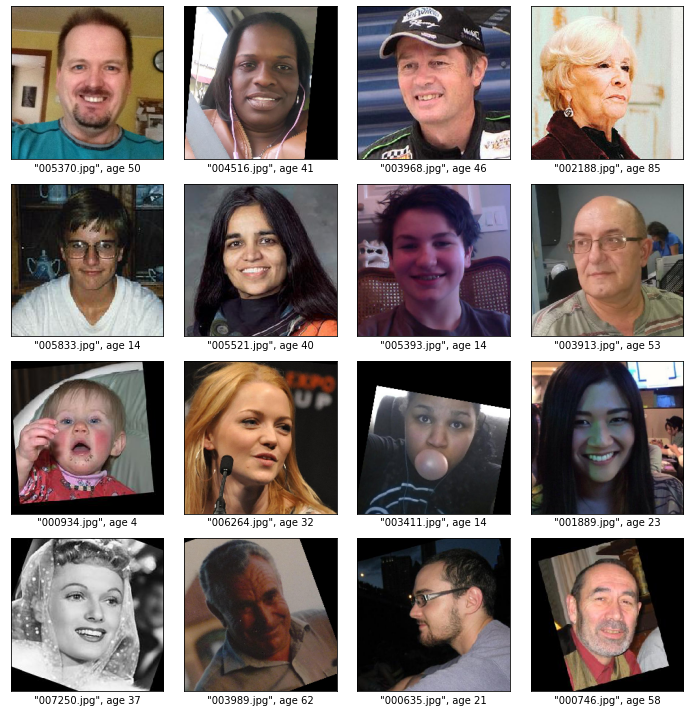

In [3]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) # i-тая картинка первого батча
    plt.xlabel(
        f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", age {train_gen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Как видно из фотографий первичная аугментация была уже сделана: некоторые фотографии искажены и смещены. Предварительная аугментация не требуется. Это так же указано в описании датасета

Узнаем больше о выборке:

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


В датасете пустых значений нет.

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


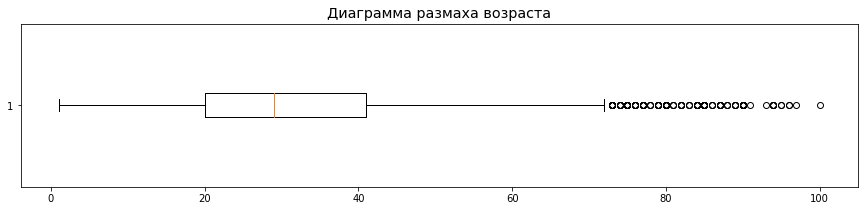

In [6]:
display(labels.describe())

plt.figure(figsize=(15,3))
plt.title('Диаграмма размаха возраста', fontsize='x-large')
plt.boxplot(labels['real_age'], vert=False)
plt.show()

Исходя из диаграммы разброса, большинство фотографий людей возрастом от 20 до 40, выбросов немного, но это тоже немного может исказить модель.

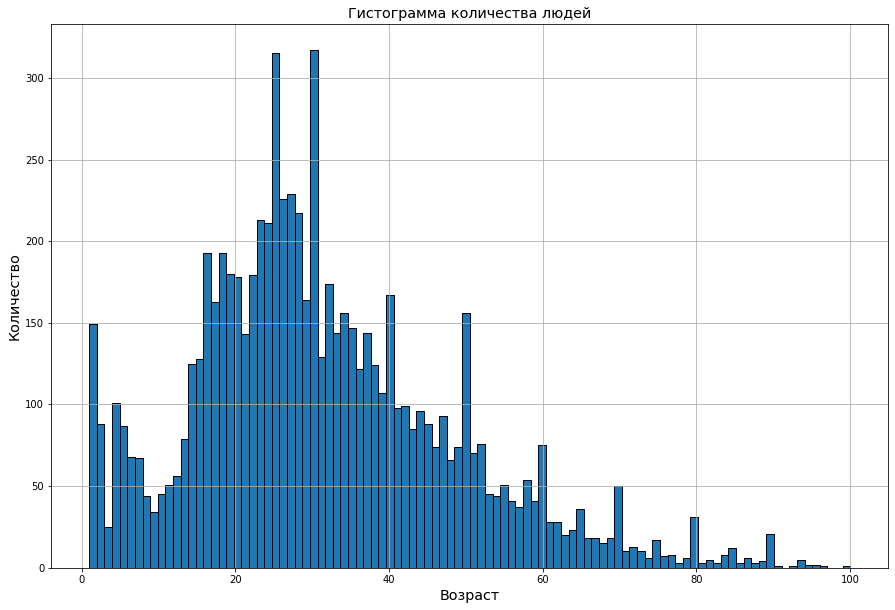

In [7]:
plt.figure(figsize=(15,10))
labels['real_age'].plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма количества людей', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

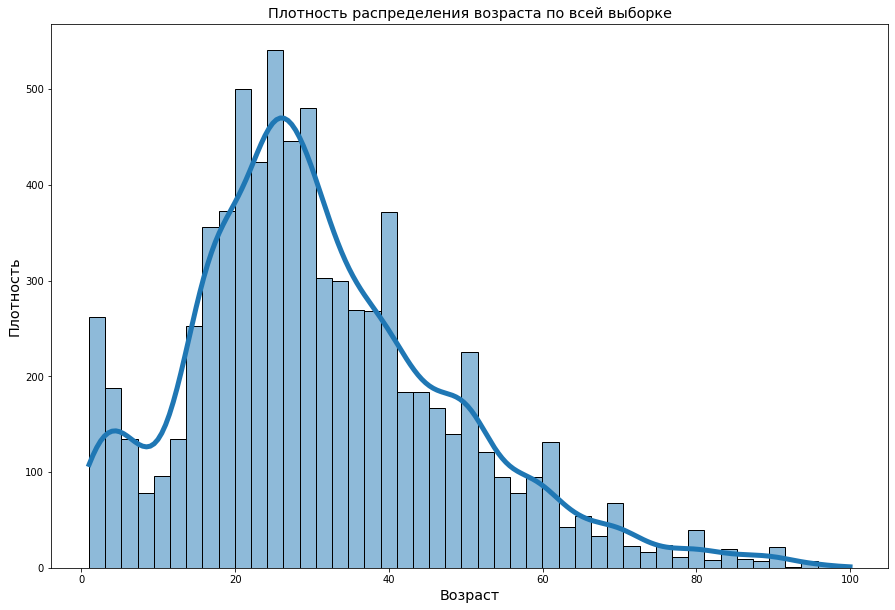

In [8]:
<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Очень информативная гистограмма</div>plt.figure(figsize=(15,10))
sns.histplot(labels['real_age'], kde=True, line_kws={'linewidth':5})
plt.title('Плотность распределения возраста по всей выборке', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Плотность', fontsize='x-large')
plt.show()

In [9]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

Выводы:
Как видно из фотографий первичная аугментация была уже сделана: некоторые фотографии искажены и смещены. Предварительная аугментация не требуется. Это так же указано в описании датасета на сайте.
В датасете есть черно-белые фотографии, изображения могут различаться по повороту, обрезке, могут быть смещены. Размер изображений отличается, но при обработке это учтено.
Исходя из диаграммы разброса, большинство фотографий людей возрастом от 20 до 40, выбросов немного, но это тоже немного может исказить модель.
Исходя из полученных графиков, большинство людей в датасете в возрасте от 20 до 35. И, возможно, что при разметке, возраст округлялся до круглых значений.

## Обучение модели

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd
import numpy as np

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
          rescale=1./255,
          validation_split=0.2
          )

    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2
      )

    test_gen_flow = test_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(
    model,
    train_datagen_flow,
    test_data_flow,
    batch_size=None,
    epochs=5,
    steps_per_epoch=None,
    validation_steps=None
    ):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow) 

    model.fit_generator(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2,
      shuffle=True
  )

    return model

Train for 190 steps, validate for 48 steps
Epoch 1/5
2022-06-10 12:25:02.356426: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-10 12:25:02.666478: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 62s - loss: 234.5346 - mae: 11.0156 - val_loss: 960.3121 - val_mae: 26.0952
Epoch 2/5
190/190 - 36s - loss: 60.5582 - mae: 5.8894 - val_loss: 707.0975 - val_mae: 21.2122
Epoch 3/5
190/190 - 36s - loss: 28.5219 - mae: 4.1572 - val_loss: 192.8496 - val_mae: 10.9271
Epoch 4/5
190/190 - 36s - loss: 19.1136 - mae: 3.3873 - val_loss: 95.0137 - val_mae: 7.4811
Epoch 5/5
190/190 - 36s - loss: 14.6854 - mae: 2.9787 - val_loss: 81.3848 - val_mae: 6.8705
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 81.3848 - mae: 6.8705
Test MAE: 6.8705

## Анализ обученной модели

Мы воспользовались моделью с ResNet, предобученной на ImageNet c слоями GlobalAveragePooling2D — пулинг с окном во весь тензор и Dense - полносвязный слой для классификации. ResNet — это глубокая сеть, которая применяет skip-connections, свёртки небольшого размера и bottleneck-блоки. На большинстве задач она работает лучше других архитектур.

При использовании данной модели, получили необходимую метрику MAE: наша модель предсказывает возраст с ошибкой ~ до 7 лет.

Данную модель можно использовать в бизнесе, но стоит обращать внимание на предсказывание модели для детей. Скорее всего данная модель не поможет в определении в определнии возраста покупателя для продажи алкоголя.

В плане накопления данных для определенных возрастных групп - тут стоит быть более аккуратным, так как средняя ошибка - 7 лет.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы